## Importing Libraries

In [3]:
import json
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pprint

## Business Dataset

In [2]:
businesses = pd.read_json('business.json', lines = True)
restaurants = businesses.drop(businesses[businesses.categories.str.contains('Restaurants') == False].index) # 59853 Restaurants
restaurants = restaurants[['business_id', 'name', 'city', 'state', 'review_count', 'stars']]
restaurants.to_csv('restaurants.csv', index = False)

## Review Dataset

Exporting full dataset to csv (estimated time: ~ 6 hours)

In [ ]:
# reviews: 'review_id', 'user_id', 'business_id', 'stars', 'date'
header_df = pd.DataFrame(columns=['review_id', 'user_id', 'business_id', 'stars', 'date'])
header_df.to_csv('restaurant_reviews.csv')
restaurant_business_ids = list(restaurants['business_id'])

chunk_size = 100000
num_checked = 0
num_reviews = 0
i = 0
chunk_dict = {}

with open('review.json', 'r', errors = 'ignore') as file:
    for line in file:
        if num_checked % chunk_size == 0:
            chunk_df = pd.DataFrame.from_dict(chunk_dict, orient = 'index')
            chunk_df.to_csv('restaurant_reviews.csv', mode = 'a', header = False, index = False)
            chunk_dict = {}
            chunk_df.drop(chunk_df.index, inplace=True)
            i = 0
            clear_output()
            print(str(num_checked / 66859)[:4] + '% done, ' + str(num_reviews) + ' reviews in dataframe at ' + time.ctime())
        review = json.loads(line)
        num_checked += 1
        if review['business_id'] in restaurant_business_ids:
            i += 1
            num_reviews += 1
            chunk_dict[i] = {'review_id': review['review_id'], 
                             'user_id': review['user_id'],
                             'business_id': review['business_id'],
                             'stars': review['stars'],
                             'date': review['date']}

Taking sample of restaurants and getting all the respective reviews

In [ ]:
restaurant_business_ids = list(restaurants['business_id'])[:100]
reviews_df = pd.DataFrame(columns = ['review_id', 'user_id', 'business_id', 'stars', 'date'])
num_checked = 0
with open('review.json', 'r', errors = 'ignore') as file:
    for line in file:
        review = json.loads(line)
        num_checked += 1
        if num_checked % 10000 == 0:
            clear_output()
            print(str(num_checked / 66859)[:4] + '% done, ' + str(len(reviews_df.index)) + ' reviews in dataframe')
        if review['business_id'] in restaurant_business_ids:
            reviews_df = reviews_df.append({'review_id': review['review_id'], 
                                            'user_id': review['user_id'],
                                            'business_id': review['business_id'],
                                            'stars': review['stars'],
                                            'date': review['date']}, ignore_index = True)

## User Dataset

In [3]:
# users: 'user_id', 'review_count', 'elite', 'yelping_since', 'average_stars'

users_df = pd.DataFrame(columns = ['user_id', 'review_count', 'elite', 'yelping_since', 'avergae_stars'])
users_df.to_csv('users.csv', index = False)

chunk_size = 100000
num_users = 0
i = 0
chunk_dict = {}

with open('user.json', 'r', errors = 'ignore') as file:
    for line in file:
        if num_users % chunk_size == 0:
            chunk_df = pd.DataFrame.from_dict(chunk_dict, orient = 'index')
            chunk_df.to_csv('users.csv', mode = 'a', header = False, index = False)
            chunk_dict = {}
            chunk_df.drop(chunk_df.index, inplace=True)
            i = 0
            clear_output()
            print(str(num_users / 66859)[:4] + '% done, ' + str(num_users) + ' users in dataframe at ' + time.ctime())
        user = json.loads(line)
        i += 1
        num_users += 1
        chunk_dict[i] = {'user_id': user['user_id'], 
                         'review_count': user['review_count'],
                         'elite': user['elite'],
                         'yelping_since': user['yelping_since'],
                         'average_stars': user['average_stars']}

23.9% done, 1600000 users in dataframe at Tue Feb 12 19:50:20 2019


In [15]:
user_dict[list(user_dict.keys())[5]]['elite']

'2015,2016,2017,2018'

# Analysis

## Sampling

In [4]:
restaurants = pd.read_csv('restaurants.csv')
# median is 20
restaurants = restaurants[restaurants['review_count'] > 20]
sample_restaurants = restaurants.sample(100, random_state = 5)

Creating user dictionary to tag reviews with their respective elite or non-elite users

In [5]:
# Make user dataset into a dictionary where the user id is the key. Then iterate through reviews and find the user
# to check whether the user was elite in the review date year
users = pd.read_csv('users.csv')
user_dict = {}
for i, user in users.iterrows():
    user_dict[user.user_id] = {'review_count': user.review_count,
                               'elite': user.elite,
                               'yelping_since': user.yelping_since,
                               'average_stars': user.avergae_stars}

/Users/kartikvasu/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


KeyboardInterrupt: 

In [ ]:
sample_restaurant_business_ids = list(sample_restaurants['business_id'])
sample_reviews_df = pd.DataFrame(columns = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'elite'])
num_checked = 0


reviews = pd.read_csv('restaurant_reviews.csv')
reviews['elite'] = False
for index, review in reviews.iterrows():
    if index % 100000 == 0:
        clear_output()
        print(str(index / 41538)[:4] + '% done, ' + str(len(sample_reviews_df.index)) + ' reviews in dataframe at ' + time.ctime())
    if review.business_id in sample_restaurant_business_ids:
        if review.user_id not in user_dict.keys():
            continue
        if review.date[:4] in str(user_dict[review.user_id]['elite']):
            review.elite = True
        sample_reviews_df = sample_reviews_df.append(review)

In [246]:
sample_restaurants.to_csv('sampled_restaurants.csv', index = False)
sample_reviews_df.to_csv('sampled_restaurant_reviews.csv', index = False)

Creating dictionary of business_id's to business objects and lists of associated reviews

In [6]:
sample_restaurants = pd.read_csv('sampled_restaurants.csv')
sample_reviews = pd.read_csv('sampled_restaurant_reviews.csv')

restaurant_dict = {}
for i, restaurant in sample_restaurants.iterrows():
    reviews = []
    for j, review in sample_reviews.iterrows():
        if review.business_id == restaurant.business_id:
            reviews.append(review.to_dict())
    restaurant_dict[restaurant.business_id] = {'restaurant': restaurant.to_dict(), 'reviews': reviews}

In [9]:
pp = pprint.PrettyPrinter(indent=2)

#pp.pprint(user_dict[list(user_dict.keys())[55]]) == None
#pp.pprint(user_dict["l6BmjZMeQD3rDxWUbiAiow"])
#pp.pprint(restaurant_dict[list(restaurant_dict.keys())[0]]['restaurant'])
#pp.pprint(restaurant_dict[list(restaurant_dict.keys())[0]]['reviews'][0]['date'][:4])
#print(restaurant_dict[list(restaurant_dict.keys())[0]]['reviews'])
for review in restaurant_dict[list(restaurant_dict.keys())[0]]['reviews']:
    if review['elite'] == True:
        weight, star = get_weights(review['date'], review['stars'])
        print(weight)
        print(star)
        
print(get_rating(sum([4.5, 3]), sum([.8, 1])))

1.0
4.0
1.0
5.0
1.0
5.0
1.0
5.0
1.0
5.0
1.0
5.0
1.0
5.0
1.0
5.0
1.0
5.0
4.167


Text(0.5,1,'Sample Restaurants Review Count')

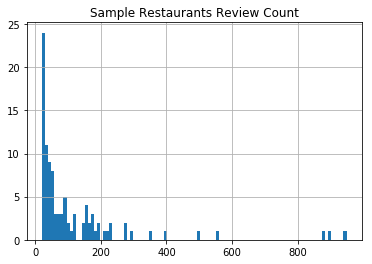

In [10]:
sample_restaurants.review_count.hist(bins = 100)
plt.title('Sample Restaurants Review Count')

In [11]:
len(sample_reviews_df.index)

NameError: name 'sample_reviews_df' is not defined

In [8]:
def get_weights(date, stars):
    years = 2018 - int(date[:4])
    weighting = 1 - years/15
    return weighting, round(stars * weighting, 3)

weight, star = get_weights("20133", 3)

def get_rating(stars, ratings):
    if ratings == 0:
        return 0
    return round(stars/ratings, 3)

print(get_rating(star, weight))

print(restaurant_dict[list(restaurant_dict.keys())[0]]['restaurant']['business_id'])

3.0
c06xDgPtZDKsI-w0Z_eujg


In [12]:
def rate_restaurants(number):
    new_ratings = pd.DataFrame(columns = ['id', 'name', 'old_rating', 'new_rating', 'review_count'])
    count = 0
    while count < number:
        ratings = []
        stars = []
        review_number = 0
        bus_id = restaurant_dict[list(restaurant_dict.keys())[count]]['restaurant']['business_id']
        name = restaurant_dict[list(restaurant_dict.keys())[count]]['restaurant']['name']
        old_rating = restaurant_dict[list(restaurant_dict.keys())[count]]['restaurant']['stars']
        reviews = restaurant_dict[list(restaurant_dict.keys())[count]]['reviews']
        for review in reviews:
            if review['elite'] == True:
                review_number+=1
                weight, star = get_weights(review['date'], review['stars'])
                ratings.append(weight)
                stars.append(star)
        new_rating = get_rating(sum(stars), sum(ratings))
        new_ratings = new_ratings.append({'id':bus_id, 'name':name, 'old_rating':old_rating, 'new_rating':new_rating, 'review_count':review_number}, ignore_index=True)
        count+=1
    return new_ratings

In [13]:
ratings_table = rate_restaurants(100)

In [31]:
ratings_table

,id,name,old_rating,new_rating,review_count
0,c06xDgPtZDKsI-w0Z_eujg,Juan's Flaming Fajitas and Cantina,5.0,4.889,9
1,iFrOVn0-f9VlYRMaRwBNRw,Boston Pizza,2.5,1.847,8
2,-uRn5Hf1uo4vf3UTtOvIfA,Don Tortaco Mexican Grill,3.0,4.086,3
3,gZ4VtOCDgK5jkPoE79RVEg,L'Atelier d'Argentine,3.5,3.339,14
4,H7z0JH-i_KqhrsZhEDBpVA,Dominion Pub and Kitchen,3.5,3.652,12
5,gvp4HXkcdlqkLZd83qxZpg,Rudy's Subs McMurray,4.5,4.048,3
6,Jur1iiejUFw_YCkfDfy1gQ,Orchids Garden Chinese Restaurant,3.5,3.624,202
7,so5zDDBvYTMjqpd0Tb8yqw,Amazing Wok,3.5,4.000,1
8,FkW_GaYtciVJPsHClk30zA,Sumo Boy Sushi and Teriyaki House,3.5,3.360,3
9,WxtjFPaPK1WGBHGQhq2bBA,Eastfield Bar & Grill,3.5,3.725,14


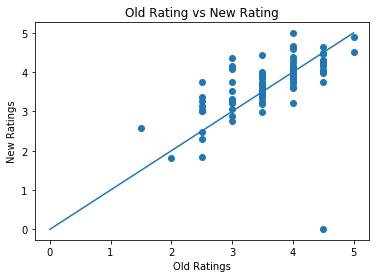

In [21]:
import matplotlib.pyplot as plt

plt.scatter(x=ratings_table['old_rating'], y=ratings_table['new_rating'])
plt.plot( [0,5],[0,5] )
plt.title('Old Rating vs New Rating')
plt.xlabel('Old Ratings')
plt.ylabel('New Ratings')
plt.savefig('old-vs-new-rating.png')

In [22]:
ratings_table[ratings_table['old_rating'] - ratings_table['new_rating'] > 2]

,id,name,old_rating,new_rating,review_count
16,AZdivItCJCjjc_H72dQLMA,Maskadores Taco Shop,4.5,0.0,0


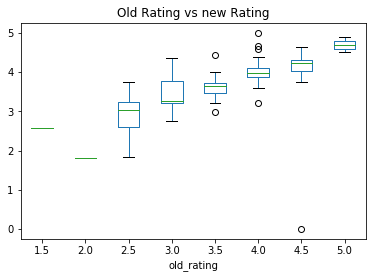

In [30]:
boxplot = ratings_table.boxplot(by='old_rating', column='new_rating', grid=False)
plt.title('Old Rating vs new Rating')
plt.suptitle("")
plt.savefig("Old-vs-new-boxplot.png")